In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from DEPENDENCIES.constants import *
from scipy.stats import norm
import DEPENDENCIES.processing as proc
import DEPENDENCIES.plot_performance as pp
from scipy.stats import ks_2samp
Z = 18  # fontsize for figures

/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [2]:
def read_text_file_pull(fname):
    """
    Reads text file with path fname
    Ignores lines with "#" and "@"
    Return array
    """
    f = open(fname, 'r')
    fl = f.readlines()
    f.close()
    
    data = []
    for line in fl[:-1]:
        if "@" not in line and "#" not in line:
            data.append(line.split())
    data = np.array(data, dtype='float')
    return data

In [3]:
def homogenize_pull(X, F, n_ignore=40):
    """
    It takes arrays X and F with the position and steering force of all the analytes in a system
    It interpolates the data to obtain forces and free energies at the positions nice_x (defined below)

    n_ignore is the number of points to ignore at the beginning and the end of the positions and forces
    n_ignore is useful when some analytes are pulled away a lot more than others (allows to homogenize the range of distances)
    """
    lens = [len(x) for x in X] + [len(f) for f in F]
    n_bottle = min(lens)
    times = X[0][:n_bottle,0]
    X = [x[:n_bottle,1:] for x in X]
    F = [f[:n_bottle,1:] for f in F]
    X = np.concatenate(X, axis=1)
    F = np.concatenate(F, axis=1)

    nice_x = np.linspace(np.min(X[:,1:]), np.max(X[:,1:]), 1000)
    #nice_x = np.linspace(1.5, 3.8, 1000)
    dx = nice_x[1] - nice_x[0]
    nice_f = []
    for i in range(len(X[0,:])):
        forces = []
        for x in nice_x:
            closest_ndx = np.argsort(np.abs(X[:,i] - x))[:2]
            if x<np.min(X[:,i]) or x>np.max(X[:,i]):
                forces.append(-1000)
            else:
                forces.append(np.mean(F[closest_ndx,i]))
        nice_f.append(forces)
    nice_f = np.array(nice_f).T 
    for i in range(len(nice_x)):
        mask = nice_f[i,:]!=-1000
        mean = np.mean(nice_f[i,mask])
        nice_f[i,~mask] = mean
    
    nice_g = []
    for f in nice_f.T:
        dg = np.cumsum(f*dx)
        nice_g.append(dg)
    nice_g = np.array(nice_g).T
    nice_g = (nice_g[n_ignore:-n_ignore] - nice_g[n_ignore:-n_ignore][-1])
    return nice_x[n_ignore:-n_ignore], nice_f[n_ignore:-n_ignore]/4.184, nice_g/4.184 #kJ to kcal"""

In [4]:
# Read the position and forces for every dyad
S = ["36","37"]
Xs_raw = [[read_text_file_pull("./S{}/PULLX/{}S{}_PULL_pullx.xvg".format(s, NA, s)) for s in S] for NA in DATA.index]
Fs_raw = [[read_text_file_pull("./S{}/PULLF/{}S{}_PULL_pullf.xvg".format(s, NA, s)) for s in S] for NA in DATA.index]

In [5]:
# Cleans the data one dayd at the time.
Xs, Fs, Gs = [], [], []
for n, NA in enumerate(DATA.index):
    print(n, NA)
    x, f, g = homogenize_pull(Xs_raw[n], Fs_raw[n])
    Xs.append(x)
    Fs.append(f)
    Gs.append(g)

0 N8A20
1 N14A20
2 N9A20
3 N6A21
4 N1A16
5 N1A17
6 N3A10
7 N3A11
8 N3A18
9 N6A20
10 N15A20
11 N7A20
12 N16A20
13 N13A20
14 N2A11
15 N2A10
16 N1A9
17 N1A8
18 N1A7
19 N1A13
20 N1A1
21 N3A19
22 N1A15
23 N1A12
24 N1A10
25 N1A14
26 N1A11
27 N2A18
28 N1A18
29 N2A19
30 N1A19


In [7]:
# Remove outliers
DATA['Score'] = [proc.reject_outliers(np.abs(np.min(g, axis=0)), iq=1.5) for g in Gs]

# Calculates mean binding free energy for each dyad
#DATA['DG_Mean'] = DATA.Score.apply(np.mean) #mean
DATA['DG_Mean'] = DATA.Score.apply(proc.boltz_mean) #mean

# Calculates standard deviation on binding free energy for each dyad
#DATA['DG_Std'] = DATA.Score.apply(lambda x: np.std(x)/(len(x)**0.5)) #ste
DATA['DG_Std'] = DATA.Score.apply(proc.boltz_std) #ste

In [8]:
#Puts dyad number as index
DATA['System'] = DATA.index
DATA.set_index(np.array(['r'+str(i) for i in np.linspace(31,1,31,dtype='int')]), inplace=True)
#DATA.set_index(np.array(['r'+str(i) for i in np.linspace(23,1,23,dtype='int')]), inplace=True)

In [9]:
np.set_printoptions(threshold=100)
#DATA.drop(['DG_Mean','DG_Std'], axis=1).to_csv("S36/DATA.csv")
DATA.to_csv("S36/DATA.csv")
np.set_printoptions(threshold=10)

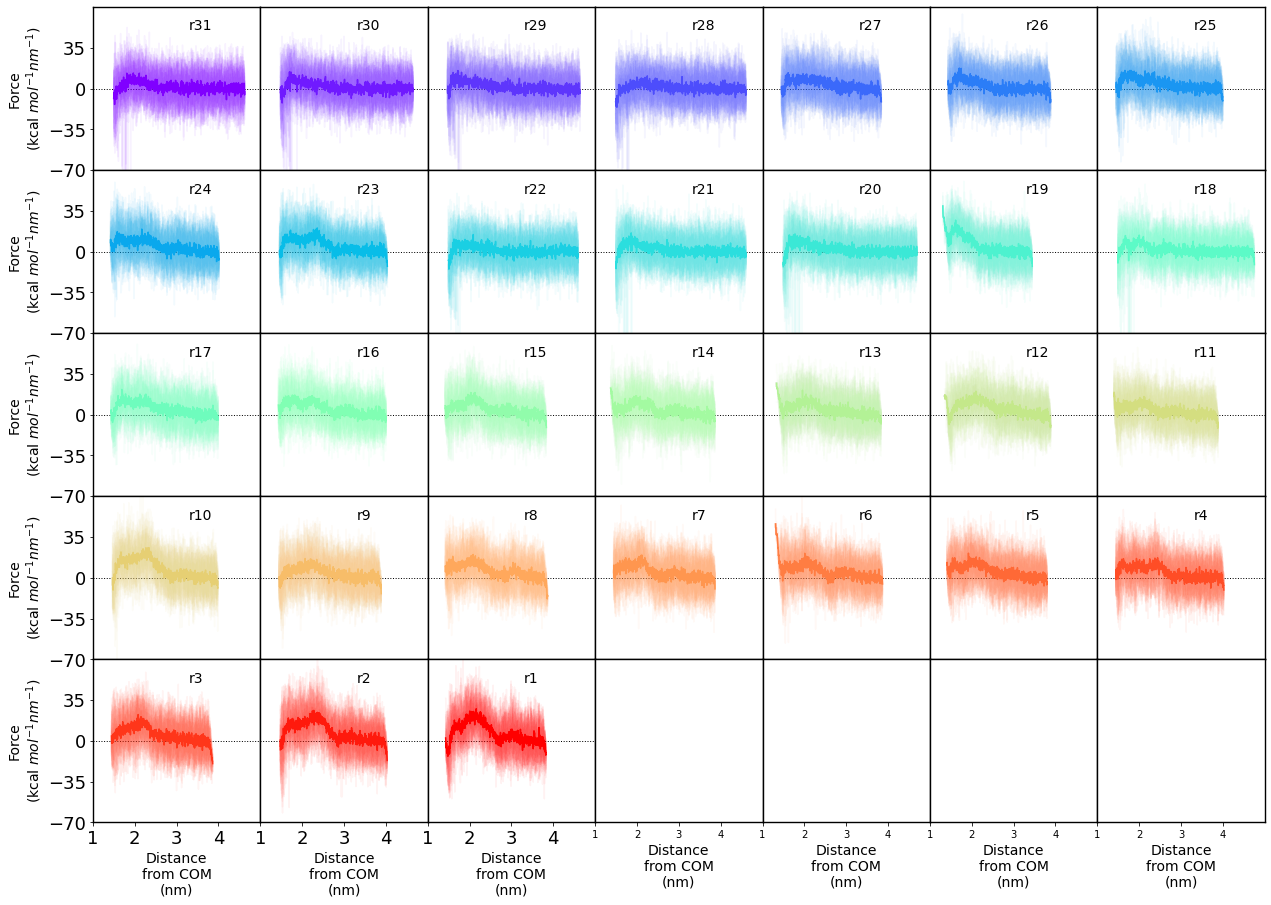

In [10]:
# Plots the steering force against the distance from the gold core for all dyads
# The profile of each analyte molecule is in transparent lines
# The mean profile of the dyad is in opaque lines
nc = 7  # columns 
nr = 5  # rows
fig, axs = plt.subplots(figsize=(nc*3,nr*3), ncols=nc, nrows=nr, subplot_kw={'xlim':(1,5), 'ylim':(-70,70), 'xticks':[], 'yticks':[]}, gridspec_kw={'wspace':0, 'hspace':0})
for ax, X, F, c, name in zip(axs.flatten(), Xs, Fs, DATA.Color, DATA.index):
    ax.axhline(y=0, lw=1, c='k', ls=':')
    ax.tick_params(labelsize=Z)
    for f in F.T:
        ax.plot(X, f, alpha=0.05, color=c)
    mean_f = np.mean(F, axis=1)
    ax.plot(X, mean_f, color=c)
    ax.text(3.3,50, name, fontsize=Z-4)
for ax in axs[:,0]:
    ax.set_yticks([-70,-35,0,35])
    ax.set_ylabel("Force\n"+r"(kcal $mol^{-1}nm^{-1}$)", fontsize=Z-4)
for ax in axs[-1,:]:
    ax.set_xticks([1,2,3,4])
    ax.set_xlabel("Distance\nfrom COM\n(nm)", fontsize=Z-4)
plt.show()
plt.close()

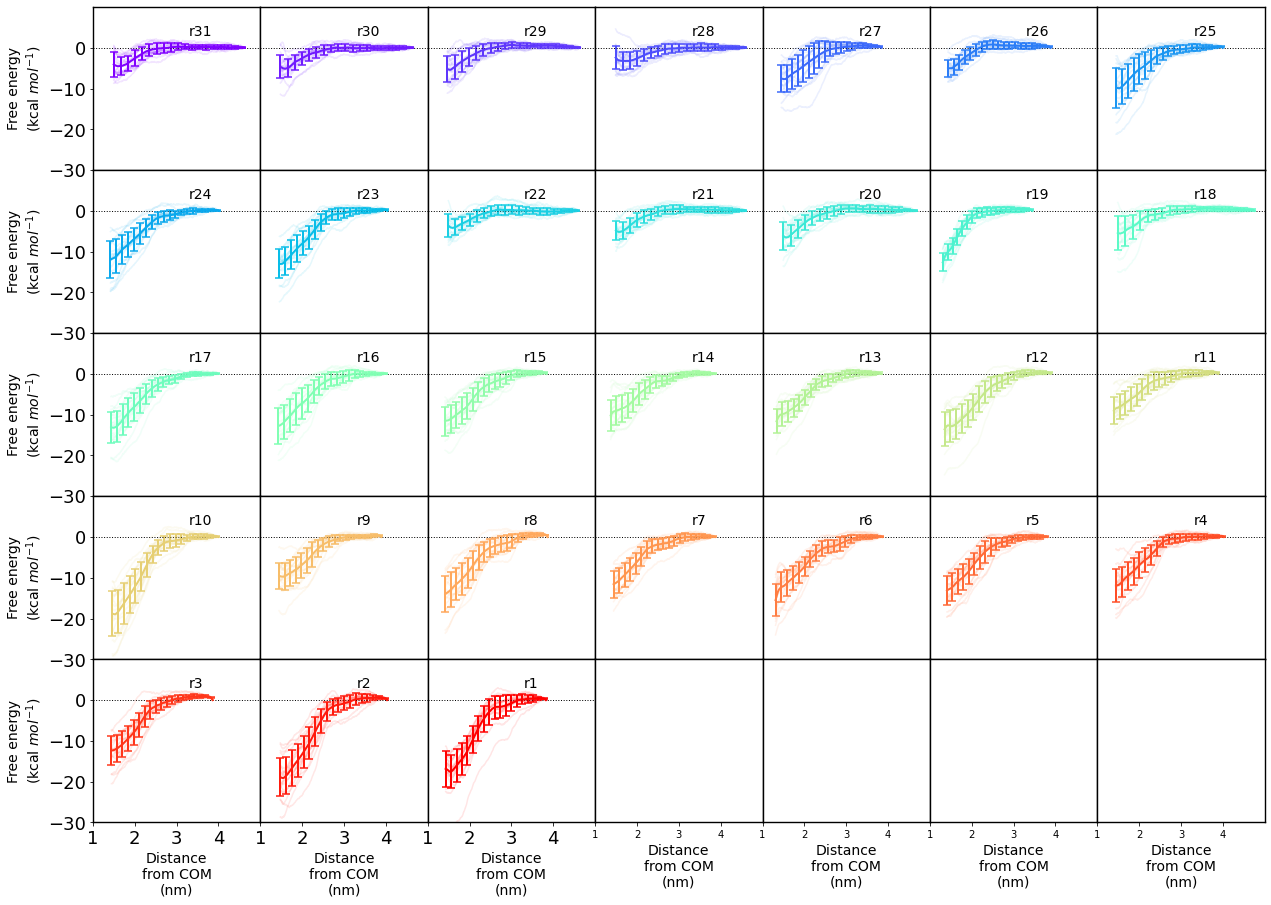

In [11]:
# Plots the potential of mean force against the distance from the gold core for all dyads
# The profile of each analyte molecule is in transparent lines
# The mean profile of the dyad is in opaque lines
nc = 7  # columns
nr = 5  # rows
fig, axs = plt.subplots(figsize=(nc*3,nr*3), ncols=nc, nrows=nr, subplot_kw={'xlim':(1,5), 'ylim':(-30,10), 'xticks':[], 'yticks':[]}, gridspec_kw={'wspace':0, 'hspace':0})
for ax, X, G, c, name in zip(axs.flatten(), Xs, Gs, DATA.Color, DATA.index):
    ax.axhline(y=0, lw=1, c='k', ls=':')
    ax.tick_params(labelsize=Z)
    for g in G.T:
        ax.plot(X, g, alpha=0.1, color=c)
    mean_g = np.mean(G, axis=1)
    #std_g = np.std(G, axis=1)/(len(G))**0.5 #ste
    std_g = np.std(G, axis=1) #standard deviation
    ax.errorbar(X, mean_g, yerr=std_g, color=c, errorevery=50, capsize=4, capthick=1.5, lw=2)
    ax.text(3.3,3, name, fontsize=Z-4)
for ax in axs[:,0]:
    ax.set_yticks([-30,-20,-10,0])
    ax.set_ylabel("Free energy\n"+r"(kcal $mol^{-1}$)", fontsize=Z-4)
for ax in axs[-1,:]:
    ax.set_xticks([1,2,3,4])
    ax.set_xlabel("Distance\nfrom COM\n(nm)", fontsize=Z-4)
plt.show()
plt.close()

In [12]:
def metric_gridsearch_dg(j_space, data=DATA):
    """
    j_space is a 1D array with all the possible free energy thresholds segregating active from inactive dyads
    Calculates accuracy, sensitivity and specificity for each of the thresholds
    Return the three metrics, for each value in j_space, as 1D arrays
    """
    accuracy, sensitivity, specificity = [], [], []
    for j in j_space:
        pred_active = (DATA.DG_Mean > j).astype('float')
        active = data.Active.astype('float')
        tp, tn, fp, fn = proc.confusion_matrix_sfu(active, pred_active)
        accuracy.append((tp+tn)/(tp+tn+fp+fn))
        sensitivity.append(tp/(tp+fn))
        specificity.append(tn/(tn+fp))
    accuracy, sensitivity, specificity = np.array(accuracy), np.array(sensitivity), np.array(specificity)
    return accuracy, sensitivity, specificity

dg_thres = np.linspace(0,30, 100)
acc, sens, spec = metric_gridsearch_dg(dg_thres, DATA)
# The quality of a free energy threshold is measured as the average of the sensitivity and specificity
opt_array = 0.5*(sens+spec)  
# If multiple threshold have the same value of opt_array, then the best decide_array will be chosen. In this case, the accuracy is the tie breaker
decide_array = acc*1
best_ndxs = np.where(opt_array==np.max(opt_array))[0]
best_ndx = best_ndxs[0]
#best_ndx = 32 #triple point
best_dg = dg_thres[best_ndx]
print("Equivalent positions (i): ", best_ndxs)
print("Chosen index: ", best_ndx)
print("Best accuracy: {:.2f}".format(acc[best_ndx]))
print("Best sensitivity: {:.2f}".format(sens[best_ndx]))
print("Best specificity: {:.2f}".format(spec[best_ndx]))
print("Best free energy threshold: {:.2f} kcal/mol".format(best_dg))
# Runs Kolmogorov–Smirnov test to determine if the free energy distributions for known active and inactive dyads are statistically different
bind_scores = np.array([l for listita in list(DATA.Score[DATA.Active==True].values) for l in listita])
unbind_scores = np.array([l for listita in list(DATA.Score[DATA.Active==False].values) for l in listita])
ks, p_val = ks_2samp(bind_scores, unbind_scores)

Equivalent positions (i):  [45]
Chosen index:  45
Best accuracy: 0.74
Best sensitivity: 0.77
Best specificity: 0.67
Best free energy threshold: 13.64 kcal/mol


In [13]:
print(p_val)  # probability with which the distributions are different

6.078445544266835e-20


In [14]:
DATA.to_csv('training_result.csv')

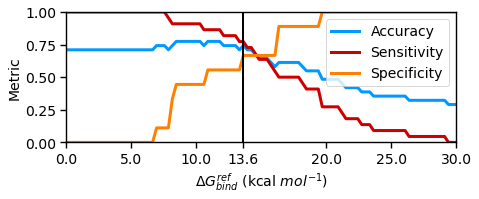

In [15]:
# Plot accuracy, sensitivity and specificity for all the possible thresholds, and the best value found
fig = plt.figure(figsize=(7,2.4))
ax = plt.axes()
ax.set_xlim(0,30)
ax.set_ylim(0,1)
ax.plot(dg_thres, acc, lw=3, label='Accuracy', c=(0,0.6,1))
ax.plot(dg_thres, sens, lw=3, label='Sensitivity', c=(0.8,0,0))
ax.plot(dg_thres, spec, lw=3, label='Specificity', c=(1.0,0.5,0))
ax.set_xlabel(r'$\Delta G_{bind}^{ref}$ (kcal $mol^{-1}$)', fontsize=Z-4)
ax.set_ylabel('Metric', fontsize=Z-4)
ax.legend(fontsize=Z-4, loc='upper right')
ax.tick_params(labelsize=Z-4, size=6, width=1.4)
ax.set_xticks([0,5,10,13.6,20,25,30])

ax.set_yticks
ax.axvline(best_dg, c='k', lw=2)
plt.savefig("S36/Metrics.png", format='png', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig("S36/Metrics.svg", format='svg', bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [16]:
from importlib import reload
reload(pp)

<module 'DEPENDENCIES.plot_performance' from '/Users/sebastian/Documents/PhD/Data/ThiolScreening/Mixtures/DEPENDENCIES/plot_performance.py'>

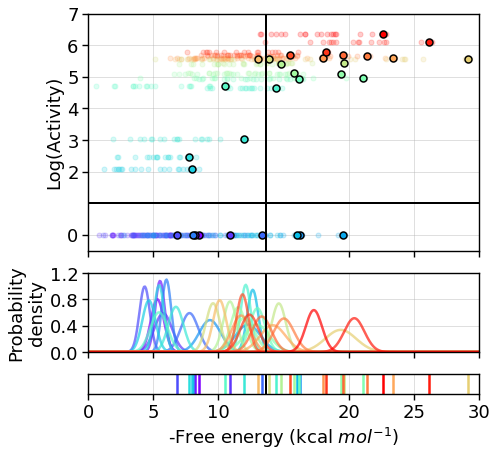

In [17]:
kwargs = {'xlim':(0,30), 'xlabel':'-Free energy '+r'(kcal $mol^{-1}$)', 'xticks':[0,5,10,20,25,30],
          'pdf_lim' : (0,1.2), 'pdf_ticks':[0,0.4,0.8,1.2],
          'distr_lim':(0,0.2), 'distr_ticks':np.linspace(0,0.2,5),
          'path':'S36', 'plot_str':'acc', 
          'figsize':(7,7), 'svg':False}

pp.plot_score_distribution(best_dg, dg_thres, data=DATA, kwargs=kwargs)
#pp.plot_score_rank(best_dg, dg_thres, data=DATA, kwargs=kwargs)

In [38]:
DATA[['Act_Mean', 'DG_Mean']].sort_values('DG_Mean')

,Act_Mean,DG_Mean
r28,0.0,6.805524
r21,300.0,7.776249
r22,120.0,7.989375
r26,0.0,8.076251
r30,0.0,8.177999
r31,0.0,8.469513
r18,50000.0,10.485319
r29,0.0,10.862372
r20,1100.0,11.959864
r9,370000.0,13.059270


# True positives

In [31]:
proc.true_positives(best_dg, DATA)

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Score,DG_Mean,DG_Std,System
r12,1,13,270000.0,30000.0,11,0,1,5.431364,0.045757,0.051153,"[0.77, 0.91, 0.54, 1.0]",True,"[14.625526068169963, 17.170591876667174, 15.58...",19.647372,0.408923,N1A13
r10,3,19,360000.0,10000.0,9,3,1,5.556303,0.011899,0.012234,"[0.9, 0.81, 0.45, 1.0]",True,"[20.51208955764064, 14.531952783555207, 12.768...",29.150396,0.243889,N3A19
r8,1,12,390000.0,30000.0,7,1,3,5.591065,0.032185,0.034762,"[1.0, 0.66, 0.36, 1.0]",True,"[22.81981582484305, 8.876653784840615, 8.16589...",23.413470,0.326636,N1A12
r6,1,14,460000.0,0.0,5,1,0,5.662758,0.000000,0.000000,"[1.0, 0.49, 0.26, 1.0]",True,"[12.933416223340368, 20.638006109071135, 15.37...",21.409560,0.544245,N1A14
r2,2,19,1300000.0,100000.0,1,0,0,6.113943,0.032185,0.034762,"[1.0, 0.1, 0.05, 1.0]",True,"[21.684241336340648, 25.53127962398435, 26.376...",26.192767,0.427435,N2A19
r1,1,19,2200000.0,100000.0,0,0,0,6.342423,0.019305,0.020203,"[1.0, 0.0, 0.0, 1.0]",True,"[18.3460890626031, 15.133580716114814, 14.8183...",22.657175,0.555303,N1A19


In [32]:
len(proc.true_positives(best_dg, DATA))

6

# False positives

In [33]:
proc.false_positives(best_dg, data=DATA)

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Score,DG_Mean,DG_Std,System


# False negatives

In [34]:
proc.false_negatives(best_dg, data=DATA)

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Score,DG_Mean,DG_Std,System
r22,6,20,120.0,5.0,21,0,0,2.079181,0.017729,0.018483,"[0.1, 0.81, 0.89, 1.0]",True,"[2.1228455468097915, 6.92519236176413, 4.01954...",7.989375,0.625502,N6A20
r21,15,20,300.0,0.0,20,0,0,2.477121,0.000000,0.000000,"[0.17, 0.87, 0.87, 1.0]",True,"[6.093380671561805, 4.5388658465979415, 7.0610...",7.776249,0.726722,N15A20
r20,7,20,1100.0,0.0,19,0,0,3.041393,0.000000,0.000000,"[0.23, 0.91, 0.84, 1.0]",True,"[4.93432236262952, 5.82248175075563, 3.9543907...",11.959864,0.590464,N7A20
r19,16,20,45000.0,0.0,18,0,0,4.653213,0.000000,0.000000,"[0.3, 0.95, 0.81, 1.0]",True,"[14.00322666953547, 11.625399540120094, 12.606...",14.439588,0.642850,N16A20
r18,13,20,50000.0,0.0,17,0,0,4.698970,0.000000,0.000000,"[0.36, 0.98, 0.78, 1.0]",True,"[5.101417551535434, 2.0443619689022094, 4.4176...",10.485319,0.646795,N13A20
r17,2,11,85000.0,15000.0,16,2,0,4.929419,0.070581,0.084321,"[0.43, 0.99, 0.74, 1.0]",True,"[16.313033785994197, 15.266570341583371, 11.10...",16.177794,0.466466,N2A11
r16,2,10,93000.0,12000.0,15,1,1,4.968483,0.052706,0.059998,"[0.5, 1.0, 0.7, 1.0]",True,"[8.787232067800229, 12.397592631713772, 14.193...",21.093548,0.438964,N2A10
r15,1,9,120000.0,20000.0,14,1,2,5.079181,0.066947,0.079181,"[0.57, 0.99, 0.67, 1.0]",True,"[13.288001067941005, 10.418017349372178, 14.50...",19.446542,0.326657,N1A9
r14,1,8,130000.0,20000.0,13,0,1,5.113943,0.062148,0.072551,"[0.64, 0.98, 0.63, 1.0]",True,"[12.3797525869843, 9.243238559463526, 12.25649...",15.772843,0.580901,N1A8
r13,1,7,260000.0,60000.0,12,1,0,5.414973,0.090177,0.113943,"[0.7, 0.95, 0.59, 1.0]",True,"[10.841493433329319, 9.672933280858, 11.149675...",14.835131,0.690375,N1A7


# True negatives

In [35]:
proc.true_negatives(best_dg, data=DATA)

,Nanoparticle,Analyte,Act_Mean,Act_Std,Act_Rank,Act_Rank_Std_up,Act_Rank_Std_down,Act_log,Act_log_error_up,Act_log_error_down,Color,Active,Score,DG_Mean,DG_Std,System
r31,8,20,0.0,0.0,30,0,8,0.0,0.0,0.0,"[0.5, 0.0, 1.0, 1.0]",False,"[1.8082644590457577, 3.601530922698876, 6.2884...",8.469513,0.653459,N8A20
r30,14,20,0.0,0.0,29,1,7,0.0,0.0,0.0,"[0.44, 0.1, 1.0, 1.0]",False,"[5.003626871298479, 7.4265624563192665, 4.7403...",8.177999,0.711083,N14A20
r29,9,20,0.0,0.0,28,2,6,0.0,0.0,0.0,"[0.37, 0.21, 0.99, 1.0]",False,"[4.3533108884663525, 5.933827031789486, 8.7490...",10.862372,0.722527,N9A20
r28,6,21,0.0,0.0,27,3,5,0.0,0.0,0.0,"[0.3, 0.3, 0.99, 1.0]",False,"[3.4480756091748703, 4.087042567332594, 2.2702...",6.805524,0.495834,N6A21
r27,1,16,0.0,0.0,26,4,4,0.0,0.0,0.0,"[0.23, 0.41, 0.98, 1.0]",False,"[9.288041475872392, 4.282236978039926, 2.73936...",13.375058,0.608908,N1A16
r26,1,17,0.0,0.0,25,5,3,0.0,0.0,0.0,"[0.17, 0.49, 0.97, 1.0]",False,"[4.550628335473629, 7.2270197983770075, 6.9246...",8.076251,0.564885,N1A17
r25,3,10,0.0,0.0,24,6,2,0.0,0.0,0.0,"[0.1, 0.59, 0.95, 1.0]",False,"[8.825919849191028, 12.486030550199187, 9.7288...",16.294997,0.486322,N3A10
r24,3,11,0.0,0.0,23,7,1,0.0,0.0,0.0,"[0.04, 0.66, 0.93, 1.0]",False,"[8.61962856575134, 8.266370530786512, 5.087257...",19.573103,0.318411,N3A11
r23,3,18,0.0,0.0,22,8,0,0.0,0.0,0.0,"[0.03, 0.74, 0.91, 1.0]",False,"[9.178812658688003, 12.993237730165722, 14.755...",16.061781,0.714138,N3A18


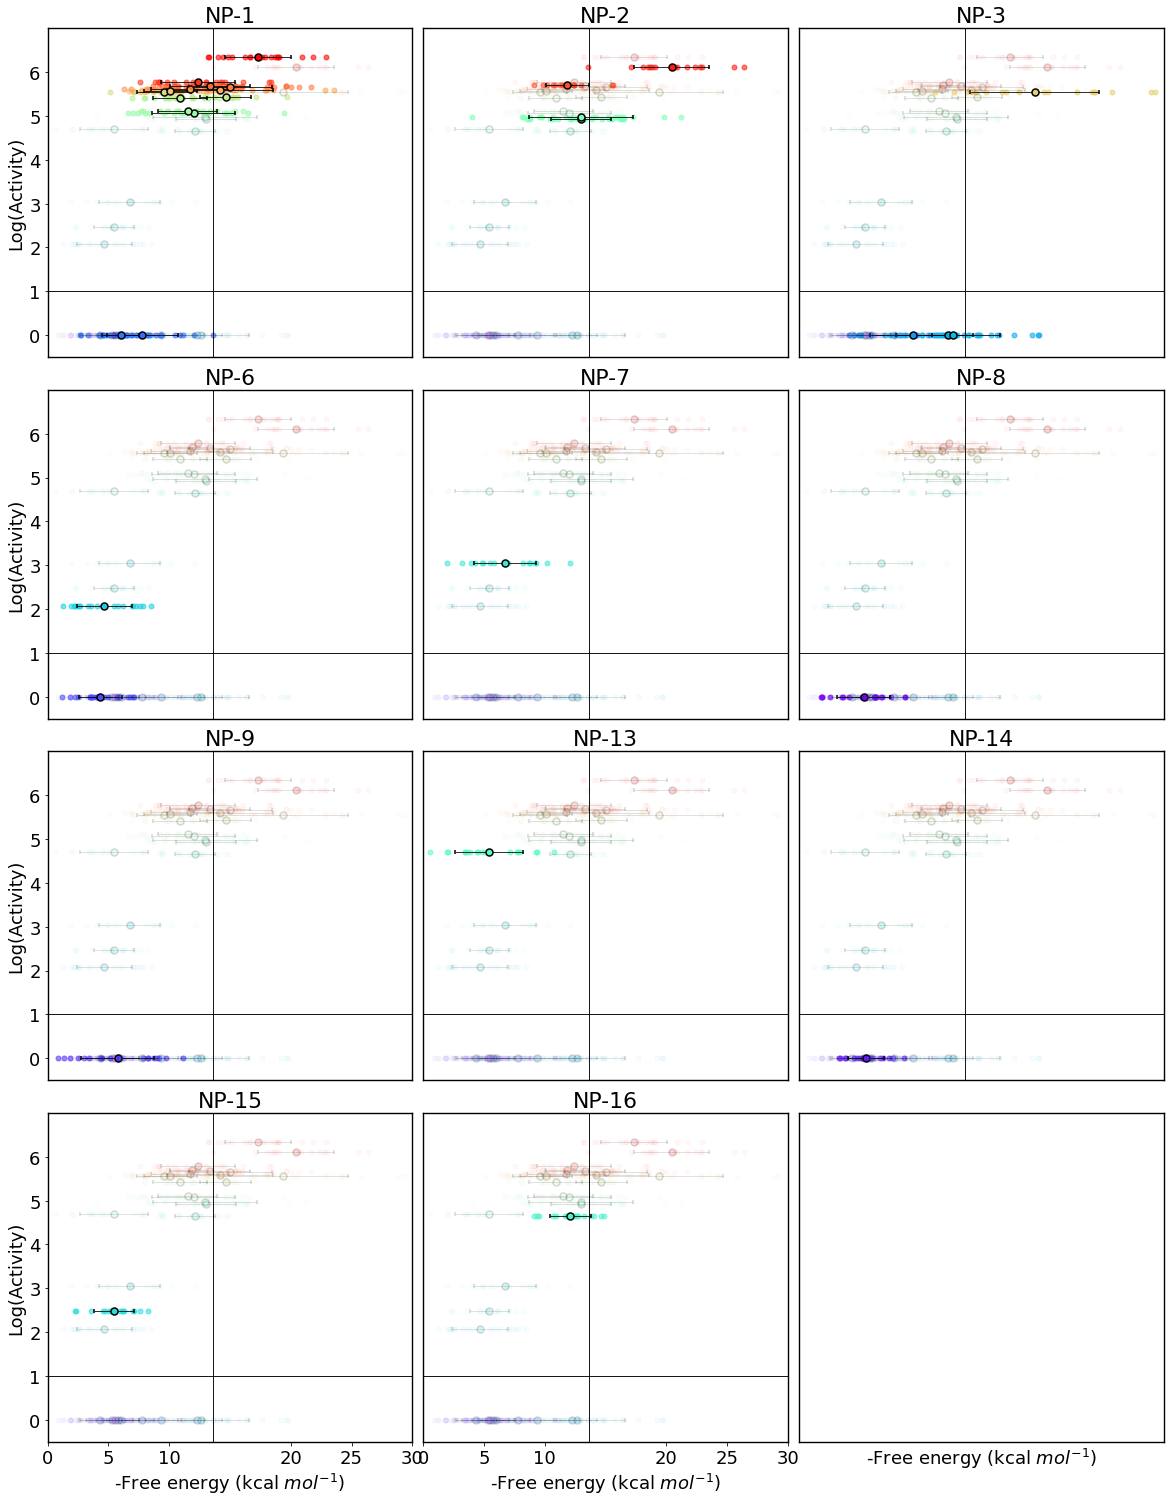

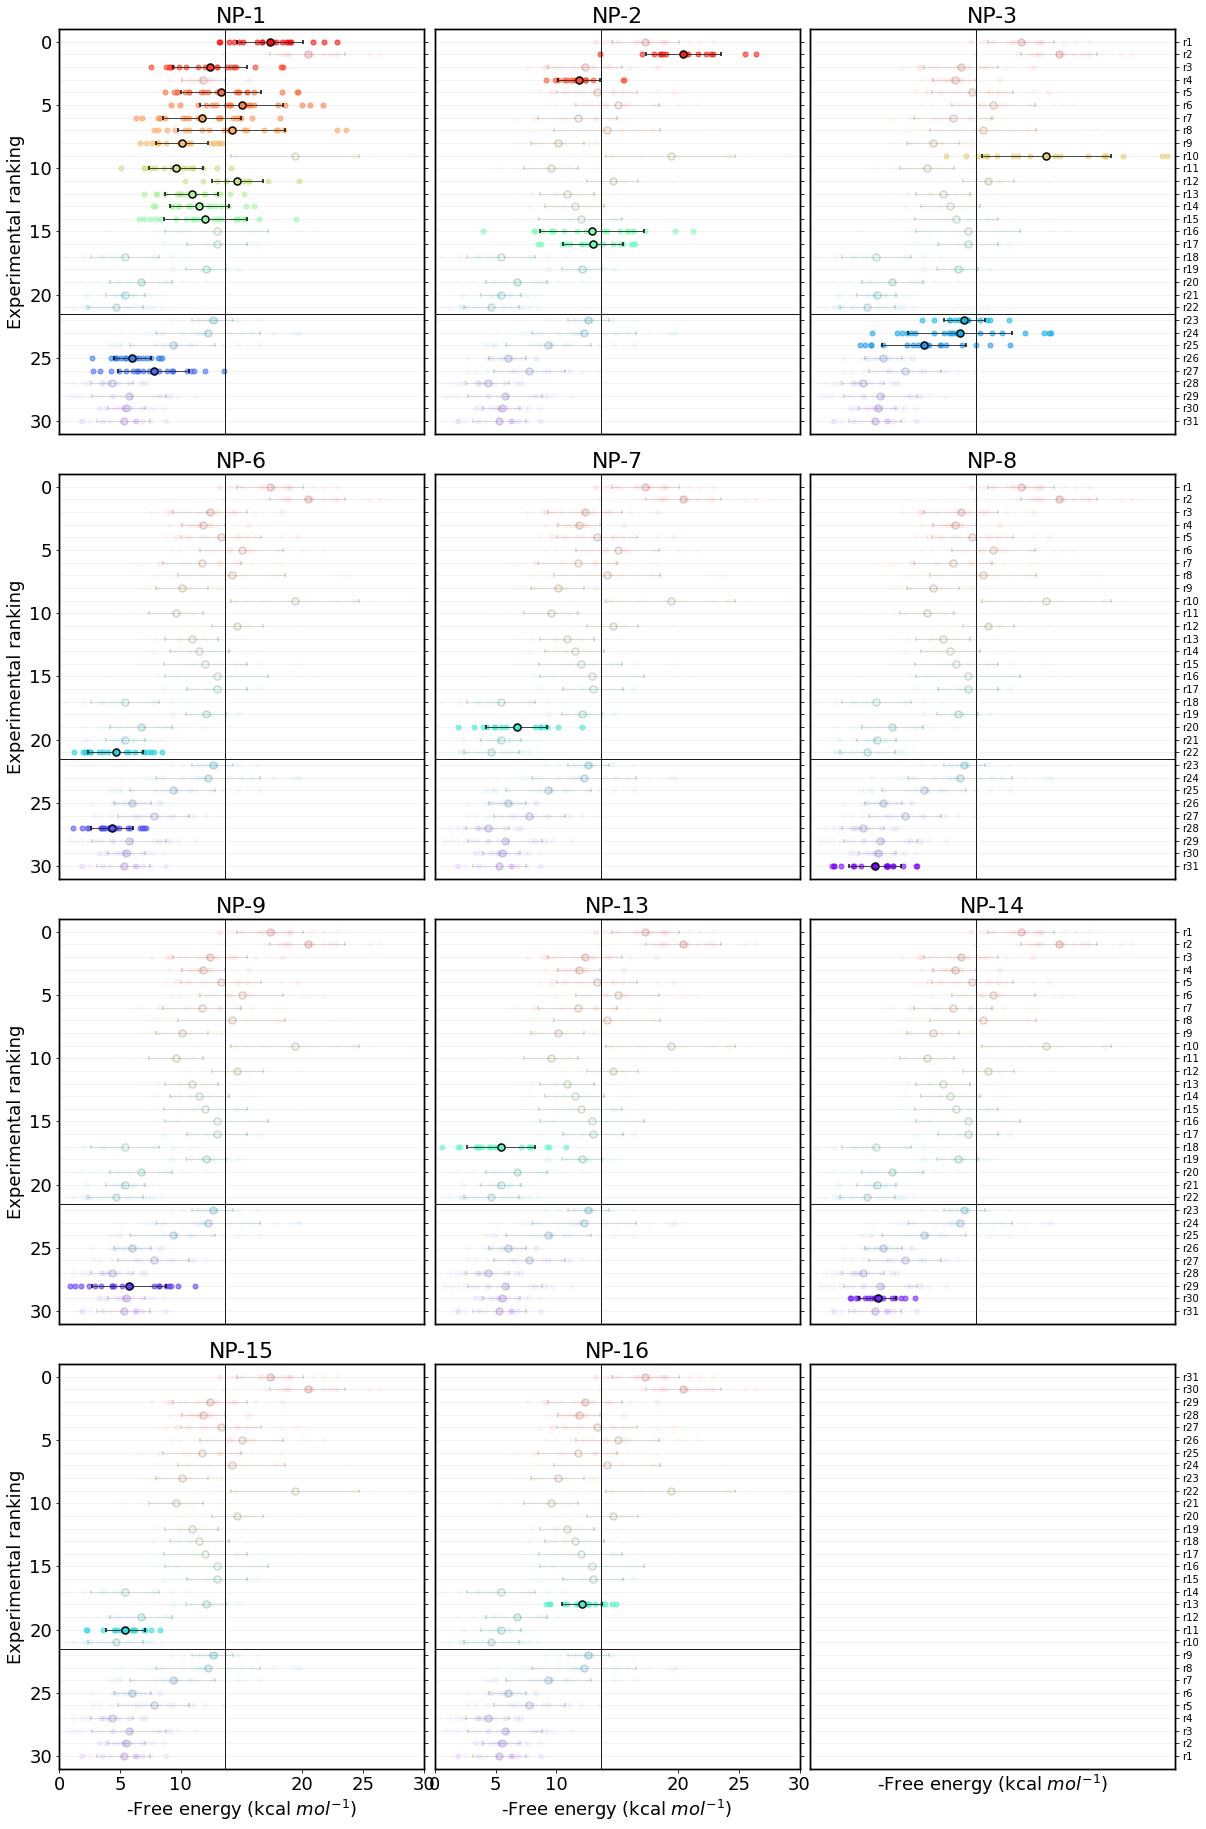

In [36]:
pp.plot_np_dependence(best_dg, data=DATA, kwargs=kwargs)
pp.plot_np_dependence_rank(best_dg, data=DATA, kwargs=kwargs)

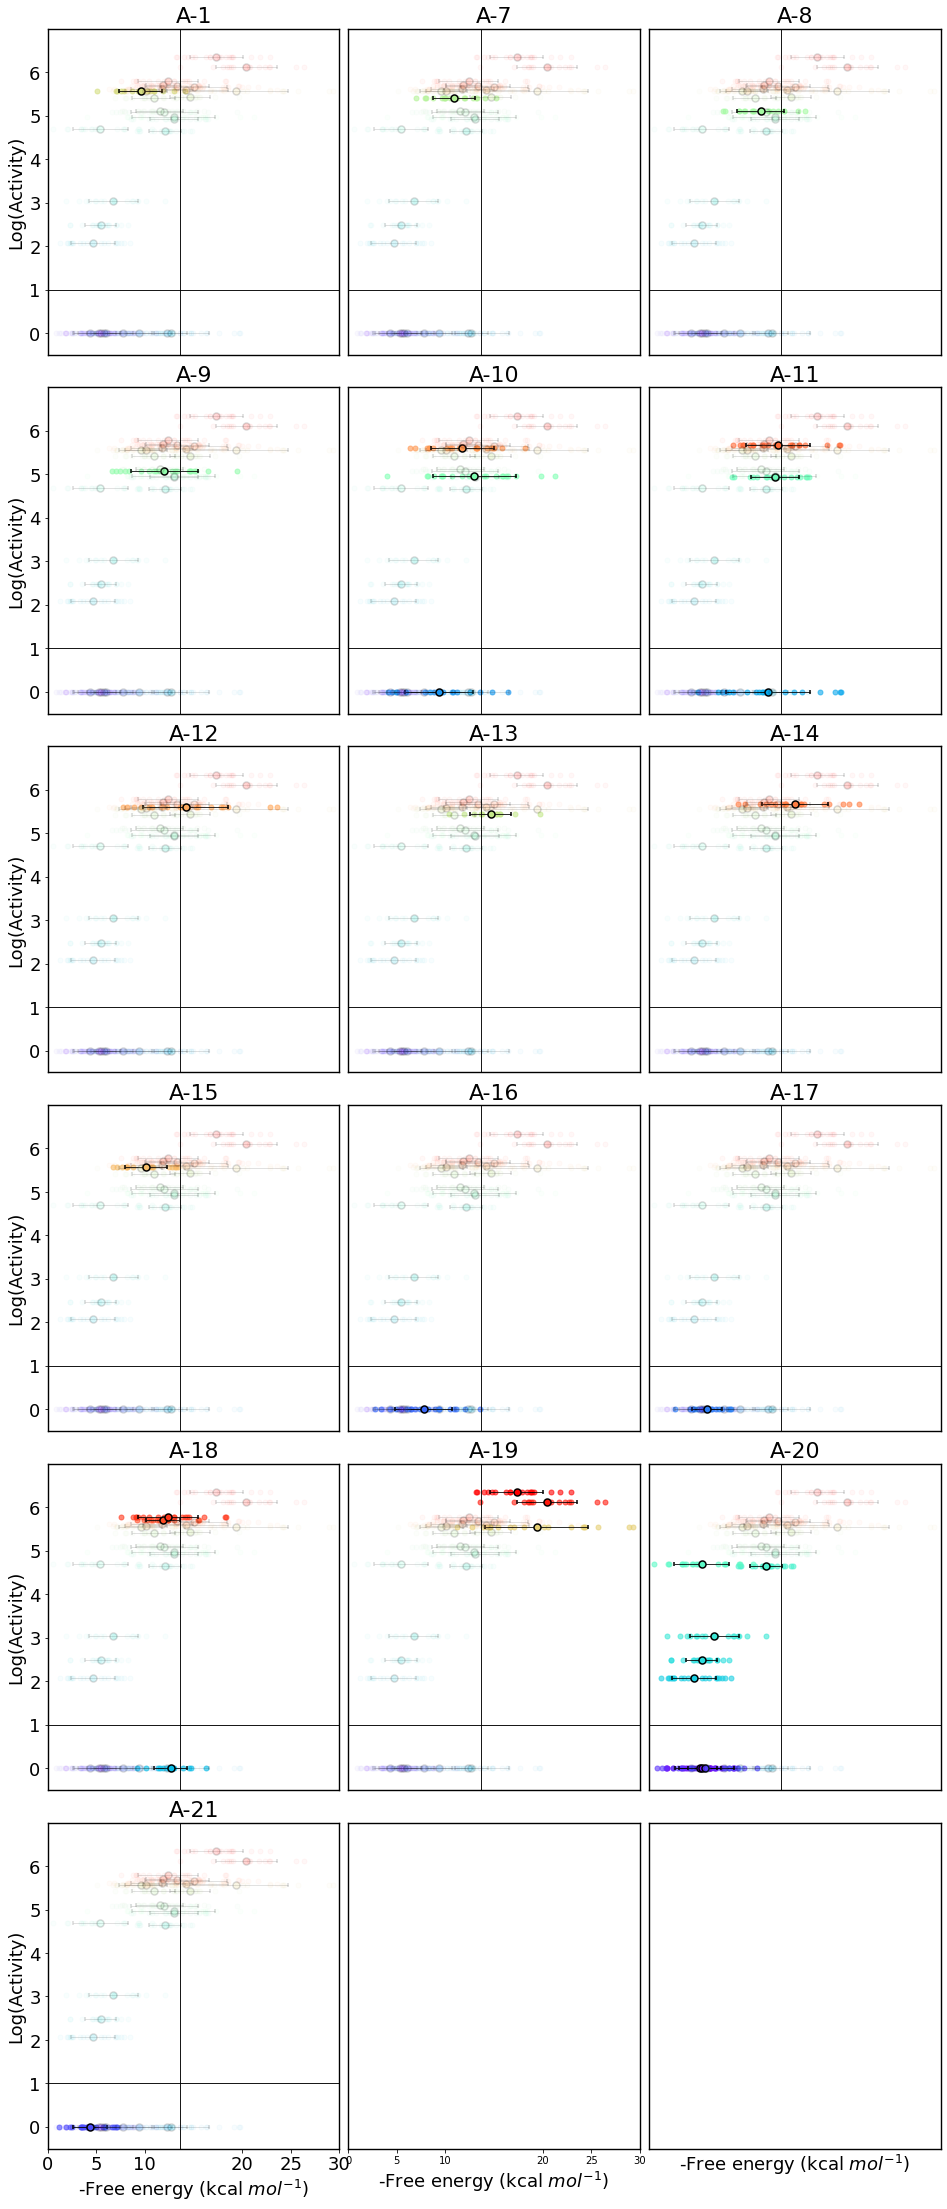

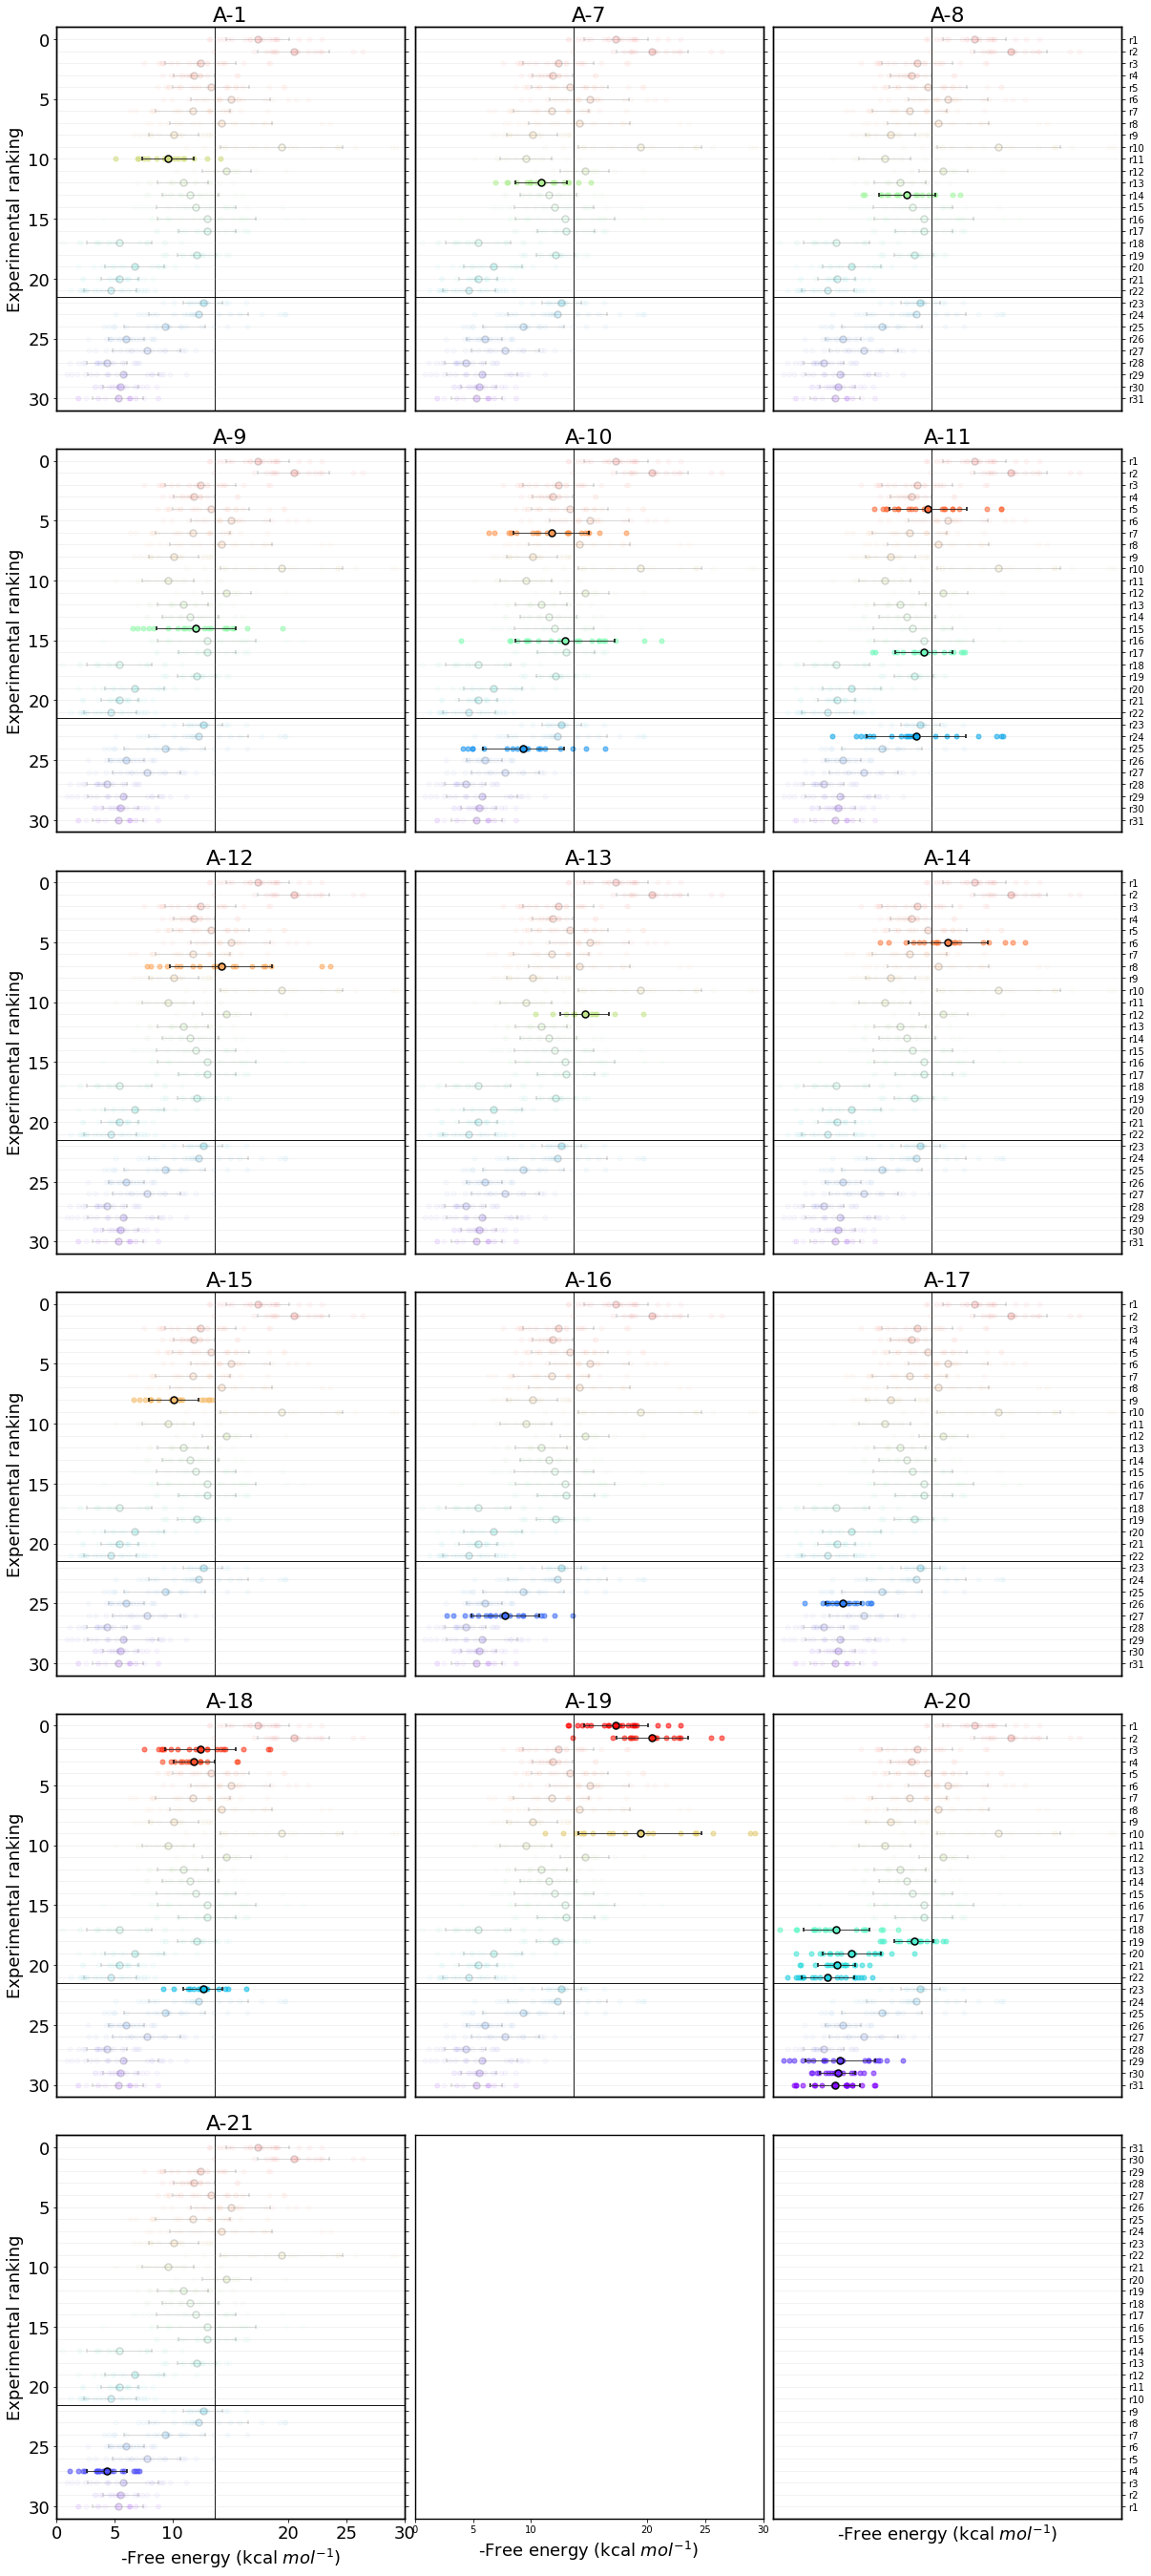

In [37]:
pp.plot_an_dependence(best_dg, data=DATA, kwargs=kwargs)
pp.plot_an_dependence_rank(best_dg, data=DATA, kwargs=kwargs)

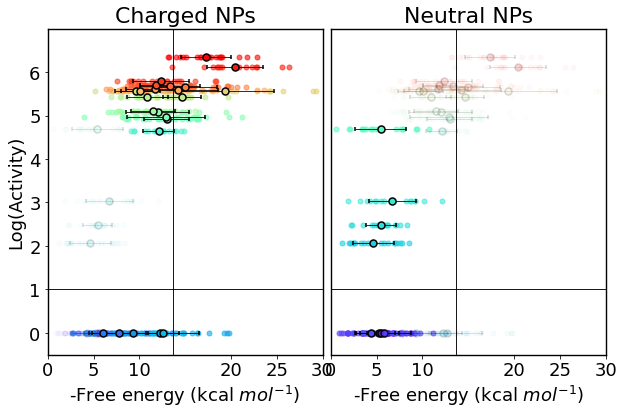

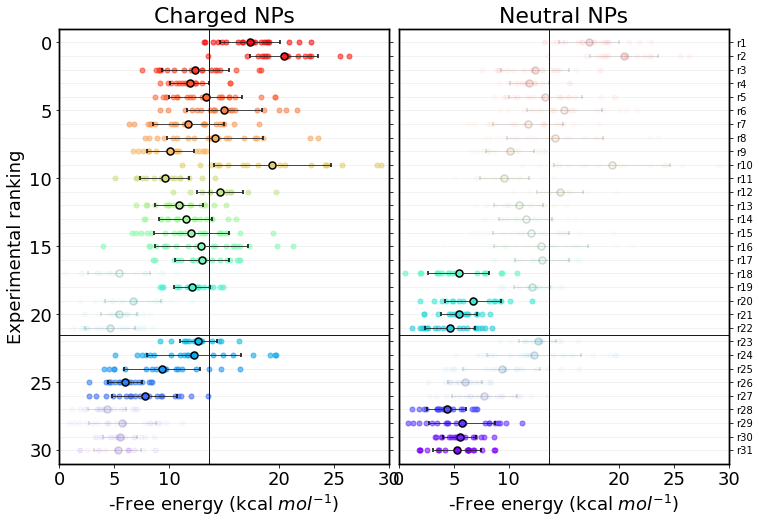

In [38]:
pp.plot_npcharge_dependence(best_dg, data=DATA, kwargs=kwargs)
pp.plot_npcharge_dependence_rank(best_dg, data=DATA, kwargs=kwargs)

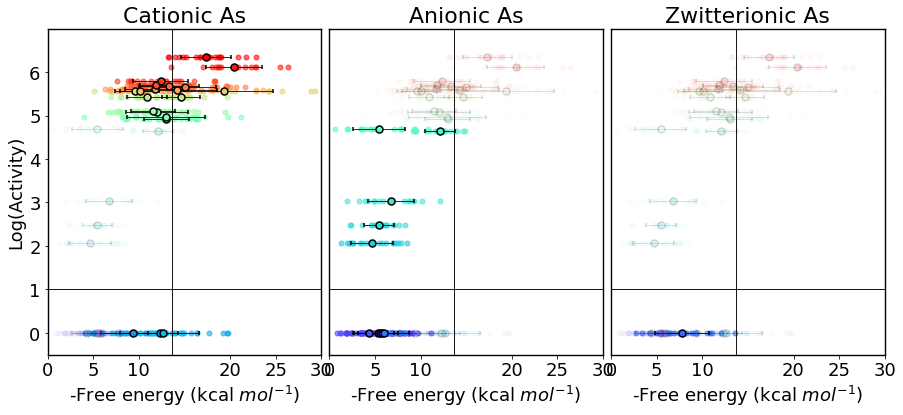

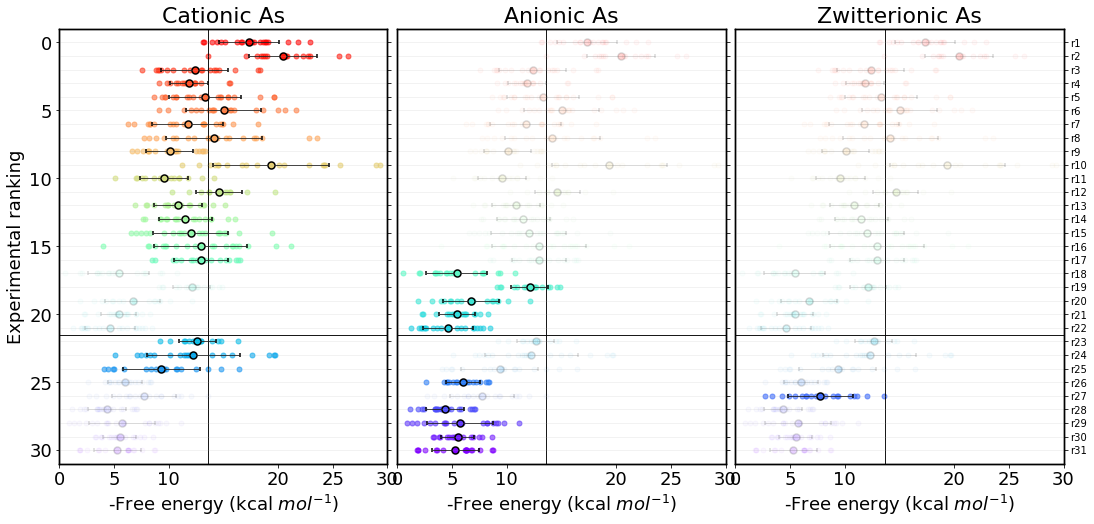

In [39]:
pp.plot_ancharge_dependence(best_dg, data=DATA, kwargs=kwargs)
pp.plot_ancharge_dependence_rank(best_dg, data=DATA, kwargs=kwargs)

In [40]:
from importlib import reload

In [46]:
reload(pp)

<module 'DEPENDENCIES.plot_performance' from '/Users/sebastian/Documents/PhD/Data/ThiolScreening/Mixtures/DEPENDENCIES/plot_performance.py'>

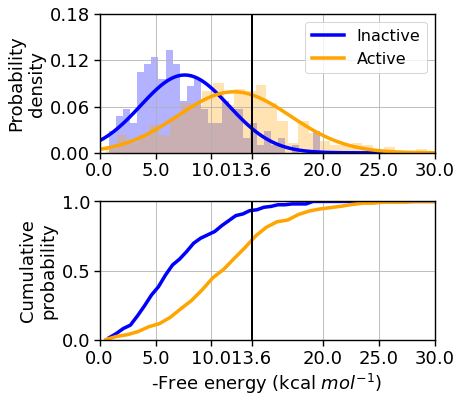

In [51]:
kwargs = {'xlim':(0,30), 'xlabel':'-Free energy '+r'(kcal $mol^{-1}$)', 'xticks':[0,5,10.0,13.6,20,25,30],
          'pdf_lim' : (0,1.2), 'pdf_ticks':[0,0.4,0.8,1.2],
          'distr_lim':(0,0.18), 'distr_ticks':np.linspace(0,0.18,4),
          'path':'S36/Accuracy', 'plot_str':'acc', 
          'figsize':(6,6), 'svg':True}

pp.plot_distributions(dg_thres, best_dg, bind_scores, unbind_scores, kwargs=kwargs)